##helper functions

In [0]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
import random
import math

In [0]:
# funcrion to read and resize an image
def read_and_resize_image(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
      img_result = cv2.bitwise_not(img_result)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return img_result

 
# function for colors arrat generation
def generate_colors(num):
  r = lambda: random.randint(0,255)
  return [(r(),r(),r()) for _ in range(num)]

#Problem 3:

## coin_calculator

In [0]:
def pixelToSize (pixel_value, dim, units):
  if units == 'mm':
    return pixel_value * ((210 / dim[0]+ 297/dim[1])/2) 
  elif units == 'cm':
    return pixel_value * ((21 / dim[0]+ 29.7/dim[1])/2)
  elif units == 'm':
    return pixel_value * ((0.21 / dim[0]+ 0.297/dim[1])/2)

In [0]:
def thresholding_coins(img_obj_gray, thresh_val, block_size, morph, use_otsu, use_morph_ope, bitwise=1, number_morph=1):
  if use_otsu:
    ret,img_bw = cv2.threshold(img_obj_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  else:
    ret,img_bw = cv2.threshold(img_obj_gray,thresh_val,255,cv2.THRESH_BINARY)
  
  kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(block_size,block_size))
  if use_morph_ope:
    for i in range(number_morph):
      img_bw = cv2.morphologyEx(img_bw, morphs[morph], kernel)

  if bitwise:
    img_bw = np.bitwise_not(img_bw)

  plt.imshow(img_bw)
  plt.xticks([]),plt.yticks([])
  plt.show()
    
  return img_bw

In [0]:
def extract_paper_coins(img, img_bw, epsilon_factor): 
  
  ######################################################   extracting the contours    ########################################################

  img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  img_contours=img.copy()
  cv2.drawContours(img_contours, contours, -1, (255,0,0), 2)

  plt.subplot(121),plt.imshow(img1)
  plt.title('binary Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(img_contours)
  plt.title('image_contours'), plt.xticks([]), plt.yticks([])
  plt.show()
  
   ###################################################   extracting the contours of the paper   ##############################################   

  contours_list=[];

  for i in range(len(contours)):
    cnt = contours[i]
    for scale in range (1, 10000):
      epsilon = epsilon_factor*0.001*scale*cv2.arcLength(cnt,True)
      approx = cv2.approxPolyDP(cnt,epsilon,True)
      if (len(approx)==4 and cv2.contourArea(approx)< 0.5*img.shape[0]*img.shape[1] and cv2.contourArea(approx)>0.2* img.shape[0]*img.shape[1]):
        contours_list.append(approx)
        break
  if len(contours_list)==0:
    import sys
    sys.exit("error!! No contour with four points found, please adjust the parameter epsilon_factor or redo the thresholding ")
    
  img_contours=img.copy()
  cv2.drawContours(img_contours, contours_list[0], -1, (255,0,0), 5)
  plt.imshow(img_contours)
  plt.title('contour paper with four points')
  plt.xticks([]),plt.yticks([])
  plt.show
  
  #####################################################   extracting the paper from the image   ##############################################  

  contour= contours_list[0]
  contour = contour[:,0,:]
  x = np.sort(contour[:,0])
  y = np.sort(contour[:,1])

  if contour[np.where(contour==x[0])[0]][0,1] < contour[np.where(contour==x[1])[0]][0,1]:
    ind0 = 0
    ind2 = 1
  else:
    ind0 = 1
    ind2 = 0
  if contour[np.where(contour==x[2])[0]][0,1] < contour[np.where(contour==x[3])[0]][0,1]:
    ind1 = 2
    ind3 = 3
  else:
    ind1 = 3
    ind3 = 2
    
#   height_= y[3]- y[0] 
#   width_= x[3]- x[0]
  height= 707 
  width= 1000

  pts1 = np.float32([[ x[ind0] , contour[np.where(contour==x[ind0])[0]][0,1] ], [ x[ind1] , contour[np.where(contour==x[ind1])[0]][0,1] ], [ x[ind2] , contour[np.where(contour==x[ind2])[0]][0,1] ], [ x[ind3] , contour[np.where(contour==x[ind3])[0]][0,1] ] ])
  pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])

  M = cv2.getPerspectiveTransform(pts1,pts2)
  img_obj = cv2.warpPerspective(img,M,(width,height))

  plt.subplot(121),plt.imshow(img_contours),plt.title('Input')
  plt.subplot(122),plt.imshow(img_obj),plt.title('Output')
  plt.show()  

  return img_obj

In [0]:
def extract_coins(img_bw, img_obj):
  
  #################################################   extracting and filtering the contours #################################################
  
  img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  img_contours=img_obj.copy()
  cv2.drawContours(img_contours, contours, -1, (255,0,0), 2)
  hierarchy = hierarchy[0,:,:]

  contours_obj=[]
  for contour, hierarch in zip(contours, hierarchy):
    if cv2.contourArea(contour)< 0.5*img_contours.shape[0]*img_contours.shape[1] and cv2.contourArea(contour)> 0.001*img_contours.shape[0]*img_contours.shape[1] and hierarch[3]==-1:
      contours_obj.append(contour)
  img_contours=img_obj.copy()
  
  if len(contours_obj)==0:
    import sys
    sys.exit("error!! No coins contours detected")
    
  cv2.drawContours(img_contours, contours_obj, -1, (255,0,0), 2)
  plt.subplot(121),plt.imshow(img_contours),plt.xticks([]),plt.yticks([]), plt.title('contours objects')
  plt.subplot(122),plt.imshow(img1),plt.xticks([]),plt.yticks([]) , plt.title('binary image')
  plt.show()
  
  ############################################################# Bounding circles ####################################################################
  
  img_circles = img_obj.copy()
  circles= np.array([[(0,0), 0]])
  
  total_value=0
  for contour in contours_obj:
    (x,y),radius = cv2.minEnclosingCircle(contour)
    center = (int(x),int(y))
    radius = radius
    
    if center[0]>0.8*radius and img_circles.shape[1] - center[0] >0.8*radius and center[1]>0.8*radius and img_circles.shape[0] - center[1] >0.8*radius: 
      radius_dist = pixelToSize (radius, img_circles.shape, 'mm')
      circles= np.append(circles, [[center, radius_dist]], axis=0)
      cv2.circle(img_circles,center,int(radius),(0,255,0),1)

      if radius < 41:
        cv2.putText(img_circles,'1', center, cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3)
        total_value +=1
      elif radius < 45 and radius >= 41:
        cv2.putText(img_circles, '10', center, cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3)
        total_value +=10
      elif radius >= 45:
        cv2.putText(img_circles, '5', center, cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3)
        total_value +=5

  
  circles= circles[1:, :]
  
  plt.imshow(img_circles)
  plt.title('bounding circle'), plt.xticks([]), plt.yticks([])
  
  return total_value
  

In [0]:
def coins_calculator (image, parameters):
  
  #################################################### converting and blurring original image #################################################
  img_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  block_size_blur=21
  img_gray = cv2.GaussianBlur(img_gray,(block_size_blur,block_size_blur),0)
  img_gray = cv2.medianBlur(img_gray,block_size_blur)
  
  ##################################################### extracting the paper from image ######################################################## 
  edges = cv2.Canny(image,20,50)
  plt.imshow(edges)
  plt.xticks([]),plt.yticks([])
  plt.show()
  img_bw= thresholding_coins(edges, parameters[0], parameters[1], parameters[2], parameters[6], parameters[7], number_morph= parameters[9])

  cond = input("if the result of the thresholding is satisfiable (the paper is detected as foreground) click 1, 0 otherwise ")
  if cond=='0':
    import sys
    sys.exit("Please adjust the parameters of the first thresholding (thresh_val1, block_size1 and morph1) and rerun the code")
             
  img_obj= extract_paper_coins(image, img_bw, parameters[8])
  
  ################################################ extracting the coins from the paper image ###################################################
  img_obj_gray = cv2.cvtColor(img_obj,cv2.COLOR_RGB2GRAY)
  img_bw= thresholding_coins(img_obj_gray, parameters[3], parameters[4], parameters[5],1, 0)
#   img_bw= thresholding_coins(img_obj_gray, parameters[3], parameters[4], parameters[5],parameters[6], parameters[7], number_morph= parameters[10] )

  total_value = extract_coins(img_bw, img_obj)
  return total_value


##main code 

photo_2019-03-01_13-35-52.jpg


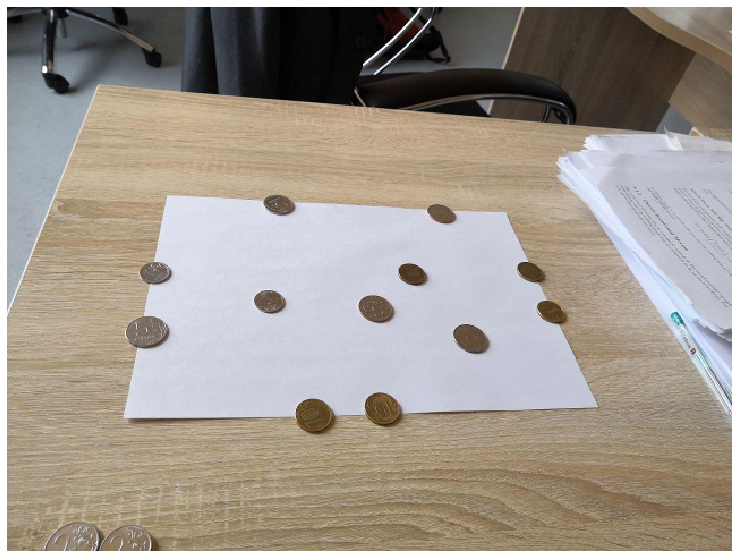

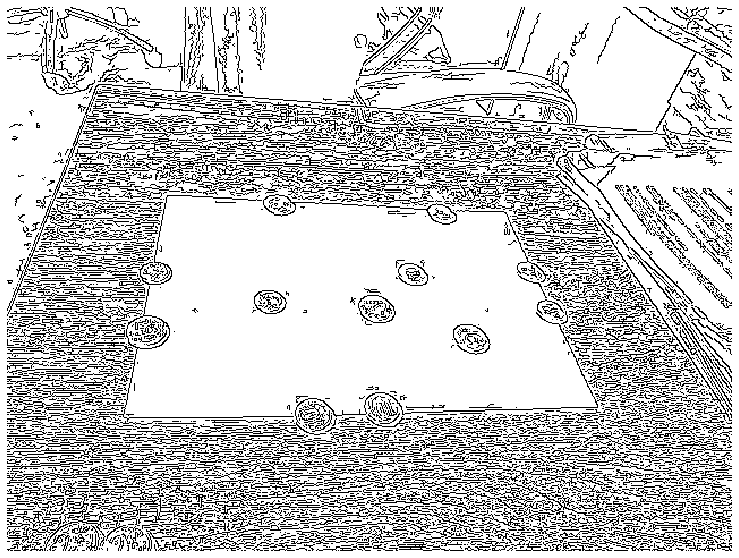

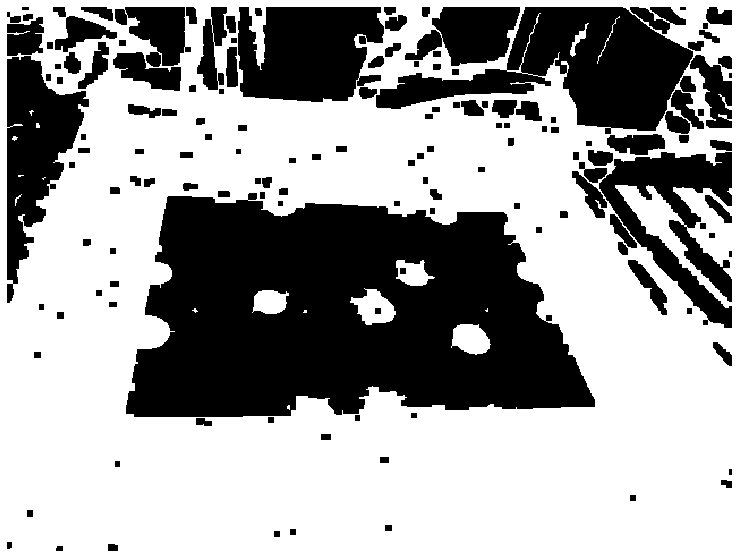

if the result of the thresholding is satisfiable (the paper is detected as foreground) click 1, 0 otherwise 1


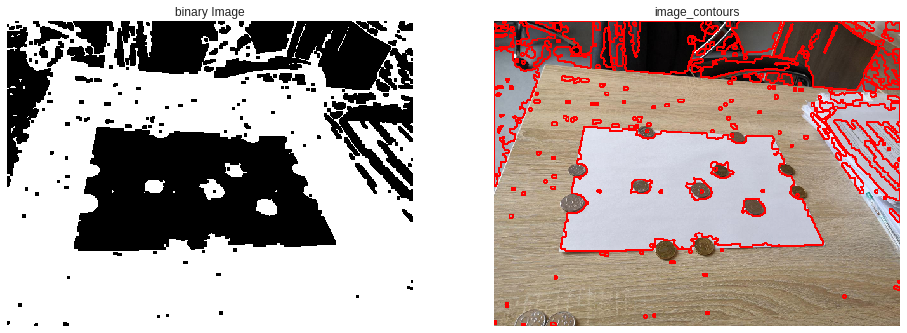

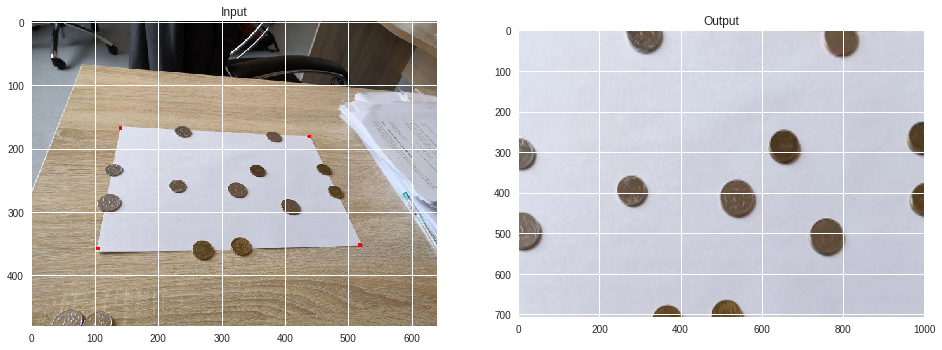

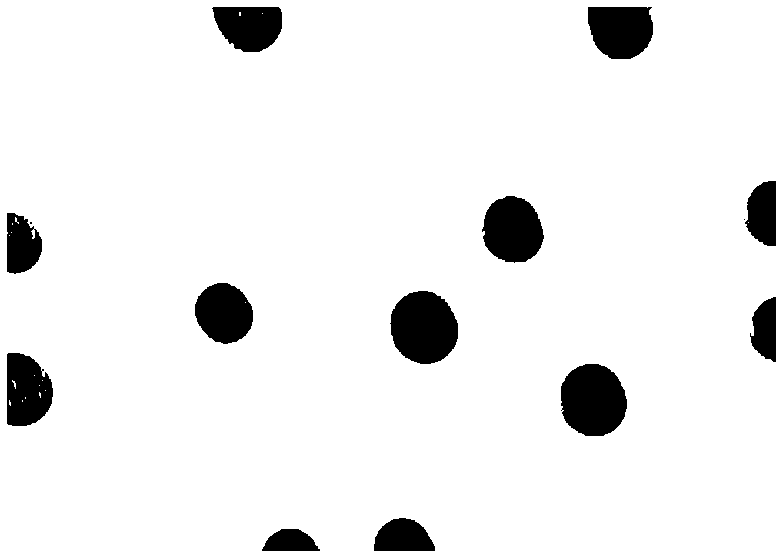

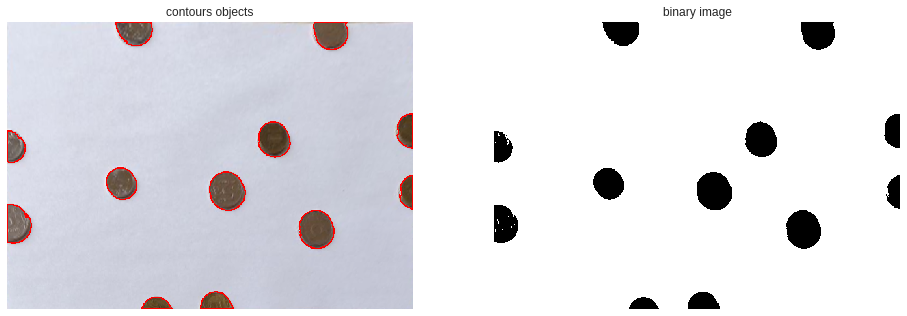

The total value of the coins is: 21


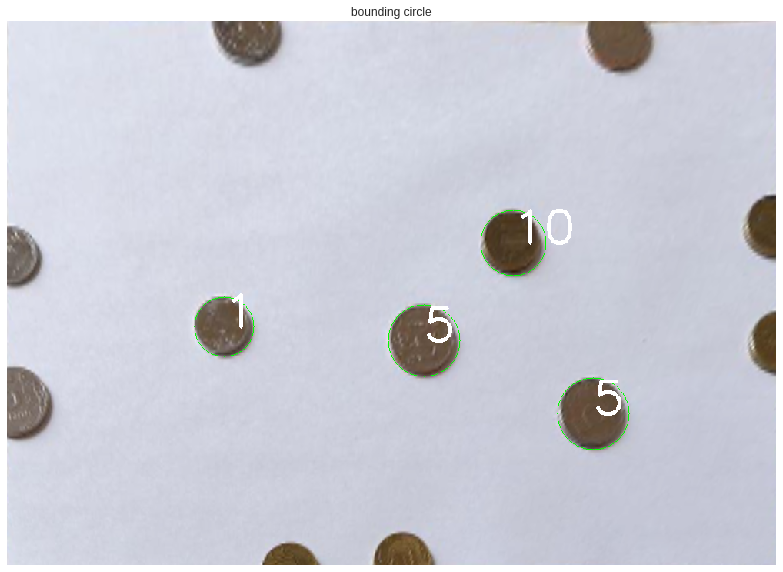

In [17]:
####################################"" main code ###########################################

#@title Threshold, block_size and type of morphological operation { run: "auto" }

images = {'image1':'photo_2019-03-01_13-35-39.jpg', 'image2':'photo_2019-03-01_13-35-40.jpg', 'image3':'photo_2019-03-01_13-35-42.jpg', 'image4':'photo_2019-03-01_13-35-43.jpg', 'image5':'photo_2019-03-01_13-35-44.jpg', 'image6':'photo_2019-03-01_13-35-45.jpg', 'image7':'photo_2019-03-01_13-35-46.jpg', 'image8':'photo_2019-03-01_13-35-47.jpg', 'image9':'photo_2019-03-01_13-35-49.jpg', 'image10':'photo_2019-03-01_13-35-50.jpg', 'image11':'photo_2019-03-01_13-35-51.jpg', 'image12':'photo_2019-03-01_13-35-52.jpg', 'image13':'photo_2019-03-01_13-35-53.jpg', 'image14':'photo_2019-03-01_13-35-54.jpg', 'image15':'photo_2019-03-01_13-35-58.jpg', 'image16':'photo_2019-03-01_13-35-59.jpg', 'image17':'photo_2019-03-01_13-36-00.jpg', 'image18':'photo_2019-03-01_13-36-01.jpg', 'image19':'photo_2019-03-01_13-36-05.jpg', 'image20':'photo_2019-03-01_13-36-06.jpg', 'image21':'photo_2019-03-01_13-36-09.jpg', 'image22':'photo_2019-03-01_13-36-10.jpg', 'image23':'photo_2019-03-01_13-36-11.jpg', 'image24':'photo_2019-03-01_13-36-13.jpg', 'image25':'photo_2019-03-01_13-36-14.jpg', 'image26':'photo_2019-03-01_13-36-15.jpg', 'image27':'photo_2019-03-01_13-36-16.jpg', 'image28':'photo_2019-03-01_13-36-17.jpg'}
image = 'image12' #@param ['image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'image8', 'image9', 'image10', 'image11', 'image12', 'image13', 'image14', 'image15', 'image16', 'image17', 'image18', 'image19', 'image20', 'image21', 'image22', 'image23', 'image24', 'image25', 'image26', 'image27', 'image28']
epsilon_factor = 1 #@param {type:"slider", min:0, max:10, step:1}

morphs = {'OPEN':cv2.MORPH_OPEN, 'CLOSE':cv2.MORPH_CLOSE}
use_default_parameters = True #@param {type:"boolean"}

if not (use_default_parameters): 
  use_otsu = False #@param {type:"boolean"}
  use_morph_ope = True #@param {type:"boolean"}

  thresh_val1 = 180 #@param {type:"slider", min:0, max:255, step:1}
  block_size1 = 5 #@param {type:"slider", min:1, max:70, step:2}
  morph1 = 'CLOSE' #@param ['OPEN', 'CLOSE']
  number_morph1 = 2 #@param {type:"slider", min:1, max:5, step:1}

else:
  thresh_val1= 180 
  block_size1= 5
  morph1= 'CLOSE' 
  number_morph1 = 2
  epsilon_factor = 1 #@param {type:"slider", min:0, max:10, step:1}
  use_otsu = False #@param {type:"boolean"}
  use_morph_ope = True #@param {type:"boolean"}
  
print(images[image])
image= read_and_resize_image(images[image], grayscale = False)

plt.imshow(image)
plt.xticks([]),plt.yticks([])
plt.show()

parameters= [thresh_val1, block_size1, morph1, 1, 1, 'CLOSE', use_otsu, use_morph_ope,  epsilon_factor, number_morph1]

total_value = coins_calculator (image, parameters)
print('The total value of the coins is: {}'.format(total_value))

In [0]:
img= read_and_resize_image('Problem3.jpg', grayscale = False)
img_gray= read_and_resize_image('Problem3.jpg', grayscale = True)

img_gray = cv2.GaussianBlur(img_gray,(21,21),0)
img_gray = cv2.medianBlur(img_gray,21)

plt.imshow(img_gray)
plt.xticks([]),plt.yticks([])
plt.show()

In [0]:
#@title Connected components { run: "auto" }
thresh_val = 107 #@param {type:"slider", min:0, max:255, step:1}

ret,img_bw = cv2.threshold(img_gray,thresh_val,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(51,51))
img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)
#img_bw = cv2.erode(img_bw,kernel,iterations = 2)

plt.imshow(img_bw)
plt.xticks([]),plt.yticks([])
plt.show()

In [0]:
img_bw[:500,:]=255

plt.imshow(img_bw)
plt.xticks([]),plt.yticks([])
plt.show()

In [0]:
img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours=img.copy()
cv2.drawContours(img_contours, contours, -1, (255,0,0), 10)

plt.subplot(131),plt.imshow(img_gray)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(img1)
plt.title('BINARY Image'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(img_contours)
plt.title('image_contours'), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
contour4=[];
area=0
for i in range(len(contours)):
  cnt = contours[i]
  epsilon = 0.05*cv2.arcLength(cnt,True)

  approx = cv2.approxPolyDP(cnt,epsilon,True)

  if (cv2.contourArea(approx) > 32999):
    print(cv2.contourArea(approx))
    contour4.append(approx)
print(len(contour4))

#     area=cv2.contourArea(approx)


5942465.0
3023401.5
2


In [0]:
img_contours=img.copy()
cv2.drawContours(img_contours, contour4[1], -1, (255,0,0), 20)
plt.imshow(img_contours)
plt.title('contour image')
# plt.xticks([]),plt.yticks([])
plt.show

In [0]:
contour=contour4[1]
contour = contour[:,0,:]
print(contour)

[[ 483  513]
 [2333  525]
 [2673 1884]
 [ 170 1932]]


In [0]:
pts1 = np.float32([[contour[0,0], contour[0,1]],[contour[1,0], contour[1,1]],[contour[3,0], contour[3,1]],[contour[2,0], contour[2,1]]])
pts2 = np.float32([[0,0],[2500,0],[0,1400],[2500,1400]])

M = cv2.getPerspectiveTransform(pts1,pts2)

img_obj = cv2.warpPerspective(img_contours,M,(2500,1400))

plt.subplot(121),plt.imshow(img_contours),plt.title('Input')
plt.subplot(122),plt.imshow(img_obj),plt.title('Output')
plt.show()

In [0]:
img_obj_gray = cv2.cvtColor(img_obj,cv2.COLOR_RGB2GRAY)
plt.imshow(img_obj_gray)
plt.title('paper image in gray scale')
plt.xticks([]),plt.yticks([])
plt.show

In [0]:
#@title Connected components { run: "auto" }
thresh_val = 140 #@param {type:"slider", min:0, max:255, step:1}

ret,img_bw = cv2.threshold(img_obj_gray,thresh_val,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17,17))
img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17,17))
img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)
img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)



# img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)
#img_bw = cv2.erode(img_bw,kernel,iterations = 2)

plt.imshow(img_bw)
plt.xticks([]),plt.yticks([])
plt.show()

In [0]:
img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours=img_obj.copy()
cv2.drawContours(img_contours, contours, -1, (255,0,0), 7)

plt.subplot(121),plt.imshow(img_contours),plt.xticks([]),plt.yticks([]), plt.title('Input')
plt.subplot(122),plt.imshow(img1),plt.xticks([]),plt.yticks([]) , plt.title('Output')
plt.show()

(Text(0.5, 1.0, 'bounding circle'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

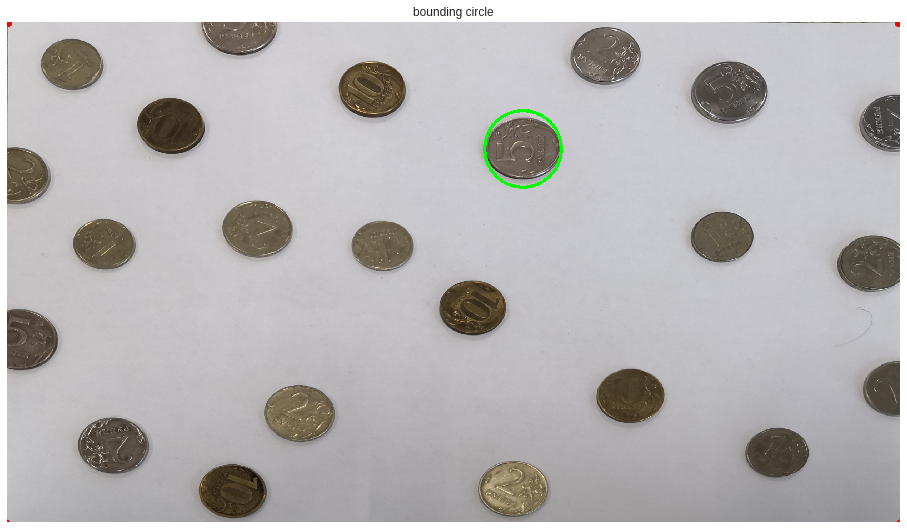

In [0]:
# Bounding circle
(x,y),radius = cv2.minEnclosingCircle(contours[10])
center = (int(x),int(y))
radius = int(radius)
img_circle = img_obj.copy()
cv2.circle(img_circle,center,radius,(0,255,0),8)

plt.imshow(img_circle)
plt.title('bounding circle'), plt.xticks([]), plt.yticks([])


center (x,y), (width, height) and angle of rotation of the object 16: ((1444.5, 355.0), (213.0, 174.0), -0.0)


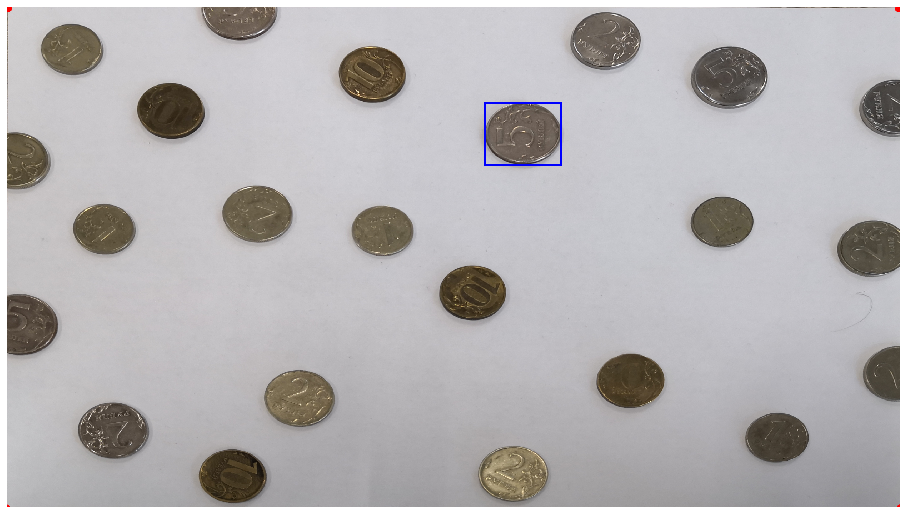

In [0]:
contour= contours[10]
# for i, contour in enumerate(contours_obj):
img_contours=img_obj.copy()
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img_contours,[box],0,(0,0,255),5)

print('center (x,y), (width, height) and angle of rotation of the object {}: {}'.format(i+1, rect) )

plt.imshow(img_contours,'gray')
plt.xticks([]),plt.yticks([]) 
plt.show()
  

In [0]:
print(rect)
x_center= rect[0][0]
y_center= rect[0][1]
height= rect[1][1]
width= rect[1][0]

((1444.5, 355.0), (213.0, 174.0), -0.0)


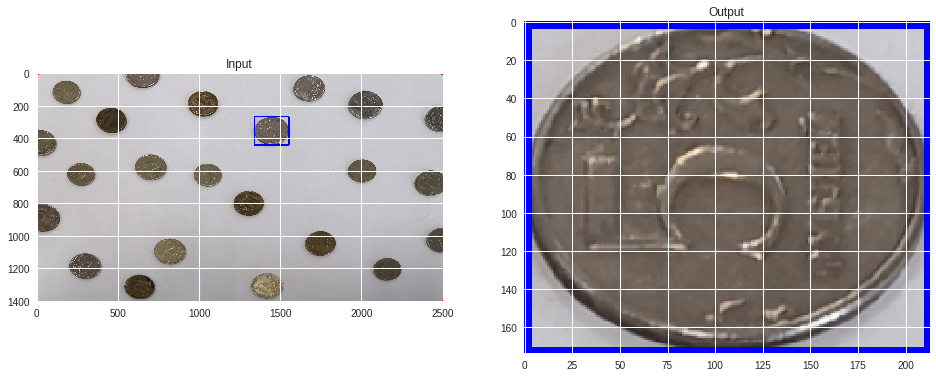

In [0]:

pts1 = np.float32([[x_center - width/2, y_center - height/2],[x_center + width/2, y_center - height/2], [x_center - width/2, y_center + height/2], [x_center + width/2, y_center + height/2]])
pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])

M = cv2.getPerspectiveTransform(pts1,pts2)

img_obj = cv2.warpPerspective(img_contours,M,(int(width),int(height)))

plt.subplot(121),plt.imshow(img_contours),plt.title('Input')
plt.subplot(122),plt.imshow(img_obj),plt.title('Output')
plt.show()

<function matplotlib.pyplot.show>

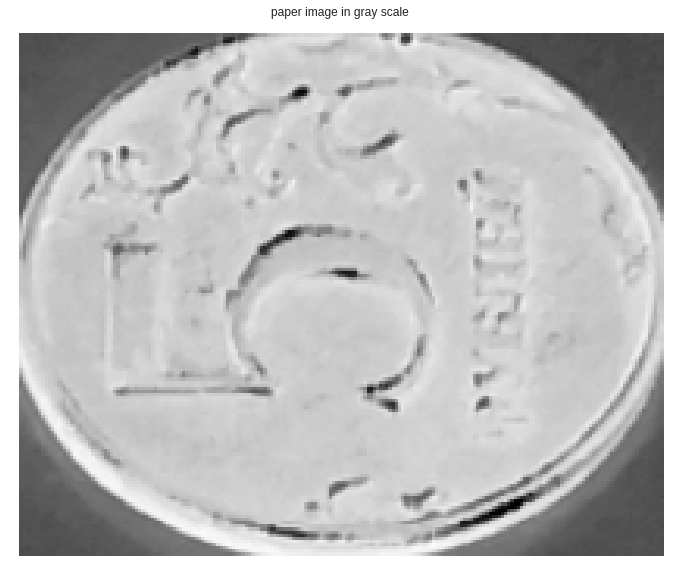

In [0]:
img_obj_gray = cv2.cvtColor(img_obj,cv2.COLOR_RGB2GRAY)
plt.imshow(img_obj_gray)
plt.title('paper image in gray scale')
plt.xticks([]),plt.yticks([])
plt.show

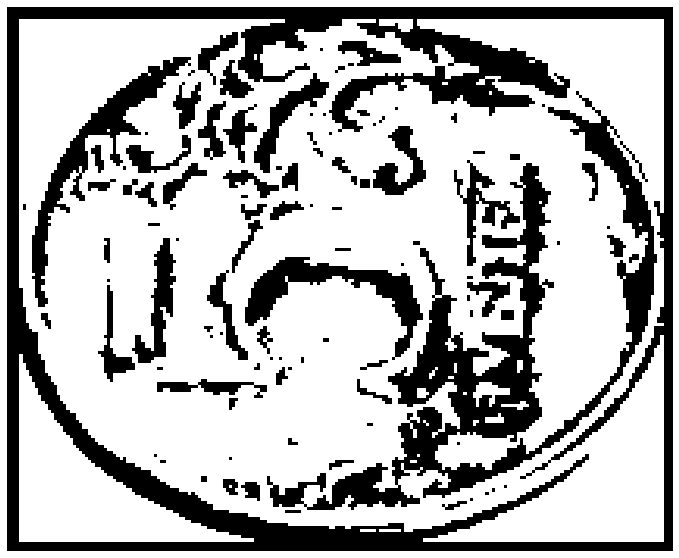

In [0]:
#@title Connected components { run: "auto" }
thresh_val = 93 #@param {type:"slider", min:0, max:255, step:1}

ret,img_bw = cv2.threshold(img_obj_gray,thresh_val,255,cv2.THRESH_BINARY_INV)

# kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(3,3))
# img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel)

# kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17,17))
# img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)
plt.imshow(img_bw)
plt.xticks([]),plt.yticks([])
plt.show()

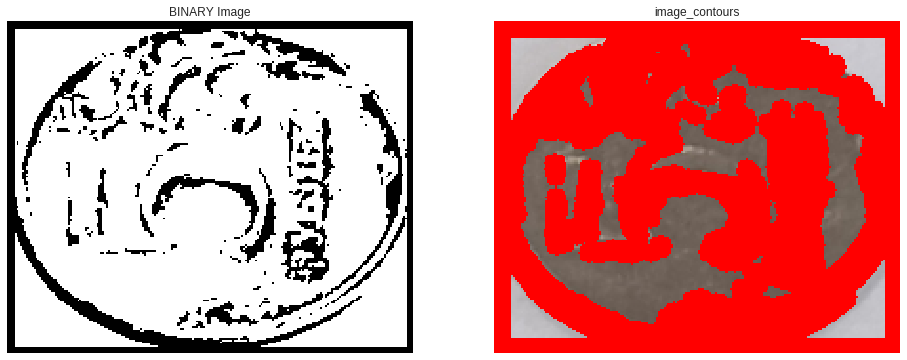

In [0]:
img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours=img_obj.copy()
cv2.drawContours(img_contours, contours, -1, (255,0,0), 10)

plt.subplot(121),plt.imshow(img1)
plt.title('BINARY Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(img_contours)
plt.title('image_contours'), plt.xticks([]), plt.yticks([])
plt.show()

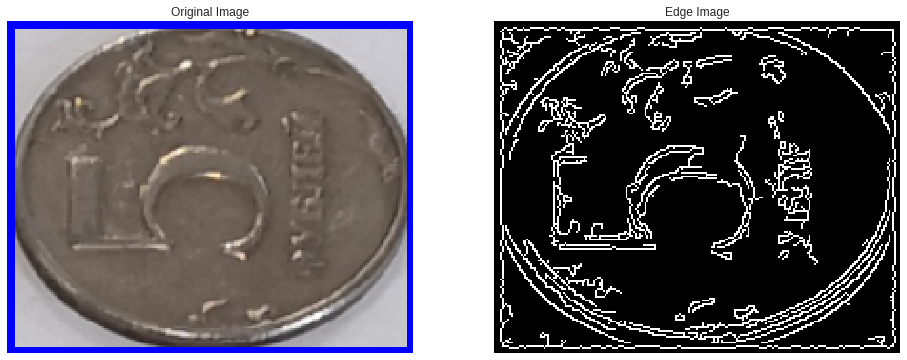

In [0]:
edges = cv2.Canny(img_obj,10,240)
 
plt.subplot(121),plt.imshow(img_obj,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

In [0]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
import random

from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import imutils
import sklearn
 
# handle older versions of sklearn
if int((sklearn.__version__).split(".")[1]) < 18:
    from sklearn.cross_validation import train_test_split
 
# otherwise we're using at lease version 0.18
else:
    from sklearn.model_selection import train_test_split

Download images

In [0]:
!wget https://lh3.googleusercontent.com/38RNGKPFhSAiA4uK9lfC6mhAu-KCJQjTF5qmXGDj2WW-UbOScKVKS-eFqY4NaNI9CUM3ersCtO_taOSE6_vwop2Kl6A4G0lPIcej2aGhNBvnCDhXLz0UNxX_620fyXWiOsEKLJBmG6RaBp0lMgLSse_XlP4ADuTTW9i1VIAcL3qYkssyDZRpVZiRNPrTKuvrGK6JbLqolbYdIEuaA8XCvnQz4YH16p-uiHWtc1HVkP6Ta-NwOvHjP4hKSBih8cVZsgp2pXLA80UBeoBRzSLe0iY3RSFefpYtcIpGWTyFLnzdBUNwChN_Kr2GBCjMTTLLXQLYGi9UTp34rS53ttTCVsNB2xJOJdV9Ok_cf0w8bsN1iA1hLEIvRsoL6qfqaBwK11sx_AnicbCr0WgCb3YBabZZXIh0LZqJiWjAHtsV4VIf_RyyJhuHWlQ9eaLEHI5f9iIp5UIupXcMzE2jVJlzbuRMiZNXqmEsilPmSfdusSMW156jyH4sI5DK--M3JjjXCFxqCh0s49hiEmfhZKG9yr22fCWmm8betTIwTwHpD-e-cEdlJaRBoQ-4JyNJ_Y479A_52hwuCNeoE_yozqJEMOiAunlRKyTycTwJISziH75IvuGqZlcfKbLzVFBo5jm8mH4dmtElDbHAYeCP6mEshdqAlxKkJk7VN83VTnRoztspqlZOWa-wh1EfwqMS1N08HlPsX0quFn6ZluB1MMU3vnTenQ=w1920-h1440-no -O keys.jpg
!wget https://lh3.googleusercontent.com/o6Lp8IhGxaWnAUl0C0dxVKljJc4vfkm0PE8HcH4kIWv2OgCWwzJBydfGcVZRTSzBxorqAyCZ1We0S9jIUqwcwwWnyZ1N-lkHy_S24v7o-cVHv_wHm_2BKPgxh2AjWBK2DGDt__dNy7mf_T-6esie3ZXYRw_KJTvcM8fbsqmfrlU1WYygU1xEnJK3237PilEGJAlN-DXuItZQxo_2PfBd6dIG0anq11Mton_8fyje8vtct2wz9kh7J_rL4fUaNNiQlvHzJqs87Y9GdP48r-JiHORzbj6aKVHfBHj-tJSdCE85ljbDvBCmgoi7LVovk5z33Eyq1-OyhQ5fsGYjEKSbphRtWCbSOOmHPu_r3mbAhEFwcCKMrTIRyoe_9sm4BKWw0wRVk--5PAptQAu9HFuQwj0exbpHyQ_8ndeRyGWs8VQDN-Qg0w5PB9bT0Y83eCyHqgs2XAk11gfPsLfw9K7RSjSy5NgcEOQU87PdgokUAtjBZWzfpmbAaE1nSj35rrHzmoSbpeCnBVcPeECzr53c9rfCtTdjrwLY1RpJ-_TtQD8eO-eIoqBE_dVKUyyITOybG6TkwZ1O36l0z-NiZO_DL75tobQhdQf8HhCSYa6zbpzlUfnnSBfSpmpN6WynyIYKw47wKhJHiQjM_QeQUYUG6M7LMb-Sq0EKsoUqveTGMlOXuHfBW_tpN9e4_q3eS3Y1il67Zkowuzkq0KQ8TxVJvYLhIA=w2000-h1000-no -O digits.png
clear_output()
print('Download completed!')
!ls

Download completed!
digits.png  keys.jpg  Problem3.jpg  sample_data
